# Cosine shift function

Implement homogeneous to inhomogeneous transformation as described in "Spectral Solution with a Subtraction Method to Improve Accuracy" by Matthew Green (Santa Clara University).

## Imports

In [1]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

## Calculate boundary derivatives and reconstruct trigonometric polynomial

In [47]:

#Differentiation matrix for forward derivatives
def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

#Differentiation matrix for backward derivatives
def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

#Vector with forward differences
def fDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

#Vector with backward differences
def bDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        #print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    #print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 

#Normalise input vector x to [0, 1]
def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order, dtype=complex) 
    b[0] = f[ 0]
    b[1] = f[-1]
    #Even derivatives at left boundary
    for i in range(1, order):
        b[i*2    ] = Dl[2*i-1]/(np.pi)**(2*i) 

    #Even derivatives at right boundary
    for i in range(1, order): 
        b[i*2 + 1] = Dr[2*i-1]/(np.pi)**(2*i) 

    return b 

def cosineDiffMat(order): 
    A = np.zeros((order*2, order*2), dtype=complex)
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A


def reconstruct(C, x, derivative_order = 0, t = 0):
    f = np.zeros(x.shape, dtype=complex)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * (np.exp(1j * (k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2
        #f += C[k-1] * (1j * k * np.pi/L) ** derivative_order * (np.cos(k * np.pi * xeval))# - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2

    return f

def getShiftFunction(f, order, x): 
    xeval = shiftx(x)
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2) + 1) 
    b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
    C = iterativeRefinement(A, b)

    shift = reconstruct(C, x)

    if 0:
        print("Absolute mismatch at boundaries")
        for i in range(order): 
            di = reconstruct(C, x, i+1)
            L  = x[-1] - x[0]
            print(f"L: {np.abs(di[0] - Dl[i]/L**(i+1)):3.3f} R: {np.abs(di[-1] - Dr[i]/L**(i+1)):3.3f}")


    return shift, C

#Momentum vector for sine transform
def computeK(p, dx):
    N = len(p)
    M = 2 * ( N + 1 )
    n = np.arange(1, int(M/2)    )
    k = 2 * np.pi / ( M * dx ) * n
    return k


## Test subroutine to calculate boundary derivatives

In [6]:
x = np.linspace(0, 2, 256)
order = 11

def func(x, derivative_order=0): 
    return np.real((1j*10)**derivative_order*np.exp(1j*10*x))

f = func(x)

#xeval = shiftx(x)
dx = x[1] - x[0]
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)

Dr = iterativeRefinement(A, b)
print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(func(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.3f} R: {np.abs(func(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.3f}")

Relative mismatch at boundaries
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.940 R: 0.000
L: 0.000 R: 0.000
L: 1.000 R: 0.000
L: 0.000 R: 0.000
L: 1.000 R: 0.000
L: 0.001 R: 0.010
L: 1.000 R: 0.032
L: 0.077 R: 0.363
L: 1.000 R: 0.110


In [22]:
x = np.linspace(-0.2, 3, 256)
order = 6

f = func(x)

xeval = shiftx(x)
dx = x[1]-x[0]#xeval[1] - xeval[0]
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)


A = cosineDiffMat(int(order/2) + 1) 
b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
C = iterativeRefinement(A, b)

shift = reconstruct(C, x)

def reconstruct(C, x, derivative_order = 0, t = 0):
    f = np.zeros(x.shape, dtype=complex)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        #f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * (np.exp(1j * (k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2
        f += C[k-1] * (1j * k * np.pi ) ** derivative_order * (np.cos(k * np.pi * xeval))# - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2

    return f

print("Relative mismatch at boundaries")
for i in range(order): 
    di = reconstruct(C, x, i+1)
    print(f"L: {np.abs(di[0] - Dl[i])/(np.abs(Dl[i])+1e-8):3.3f} R: {np.abs(di[-1] - Dr[i])/(np.abs(Dr[i])+1e-8):3.3f}")

Relative mismatch at boundaries
L: 1.106 R: 1.065
L: 0.000 R: 0.000
L: 1.099 R: 1.104
L: 0.000 R: 0.000
L: 1.072 R: 1.080
L: 0.000 R: 0.000


## Test subroutine to create shift function matching boundary conditions

In [5]:
bc_l = []
bc_r = []
for i in range(order):
    bc_l.append((i + 1,   Dl[i]))
    bc_r.append((i + 1,   Dr[i]))
bc_type=(bc_l, bc_r)

poly  = scipy.interpolate.make_interp_spline([x[0], x[-1]], [f[0], f[-1]], k = 2 * order + 1, bc_type=bc_type, axis=0)

print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(poly(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.3f} R: {np.abs(poly(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.3f}")

Relative mismatch at boundaries
L: 0.001 R: 0.000
L: 0.000 R: 0.000
L: 0.002 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000


/home/calab912/.local/lib/python3.8/site-packages/scipy/interpolate/_bsplines.py:1343: ComplexWarning: Casting complex values to real discards the imaginary part
  rhs[:nleft] = deriv_l_vals.reshape(-1, extradim)
/home/calab912/.local/lib/python3.8/site-packages/scipy/interpolate/_bsplines.py:1346: ComplexWarning: Casting complex values to real discards the imaginary part
  rhs[nt - nright:] = deriv_r_vals.reshape(-1, extradim)


## Test continuity of derivatives after shift using FFT

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


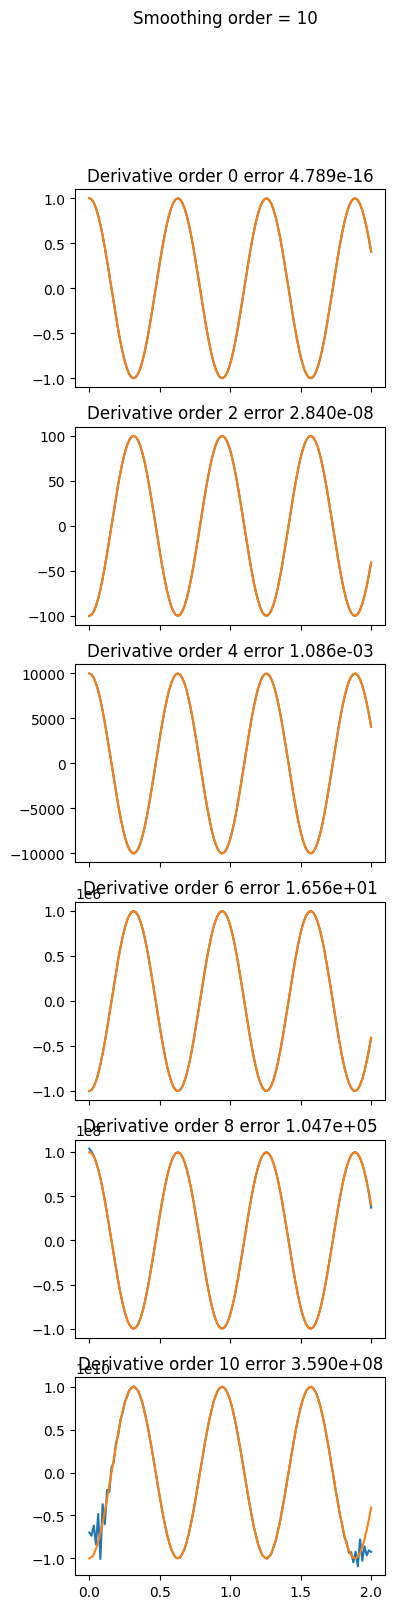

In [48]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.real((1j*10)**derivative_order*np.exp(1j*10*x))
    #return np.imag((1j*np.pi)**derivative_order*np.exp(1j*np.pi*x))

f = func(x)

N = 10
N_derivative = 6

shift, C = getShiftFunction(f, N, x) 
hom  = f - shift
fhat = scipy.fft.dst(hom[1:-1], type=1) 
fig, ax = plt.subplots(N_derivative, 1, sharex=True, figsize=(4,N_derivative*3)) 
fig.suptitle(f"Smoothing order = {N}")
for i in range(N_derivative): 
    k    = computeK(fhat, dx)
    frec = scipy.fft.idst(fhat * (1j*k)**(i*2), type=1)
    frec = np.pad(frec, (1, 1), mode="constant")
    
    reco = reconstruct(C, x, i*2)
    sumo = frec + reco 

    fref = func(x, i*2) 
    ax[i].set_title(f"Derivative order {i*2} error {np.mean(np.abs(sumo-fref)):3.3e}")
    ax[i].plot(x, sumo, label="sum") 
    ax[i].plot(x, fref, label="ref") 
    
plt.savefig(f"cosine_order_{N}.png")
plt.show()
plt.close()

## Test decay of Fourier coefficients

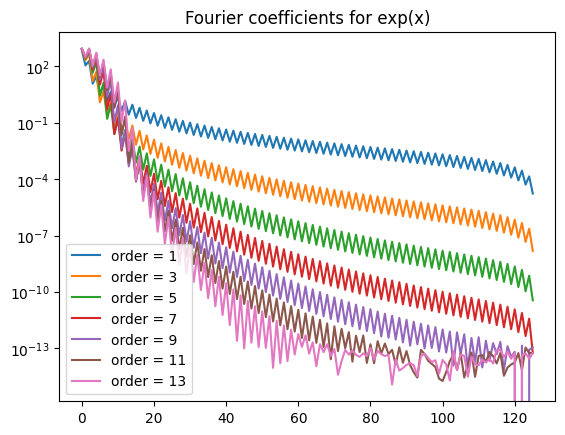

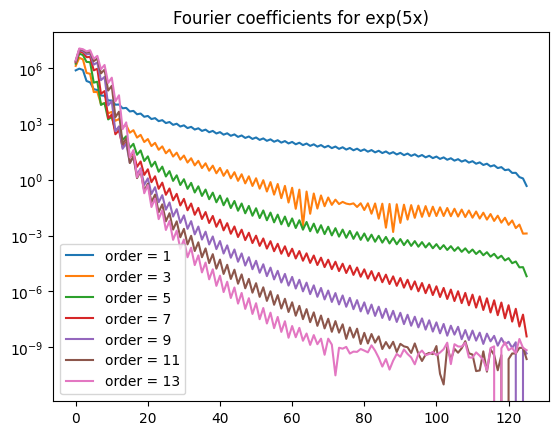

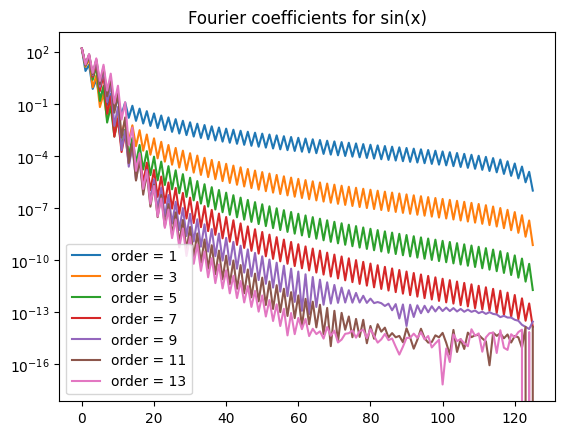

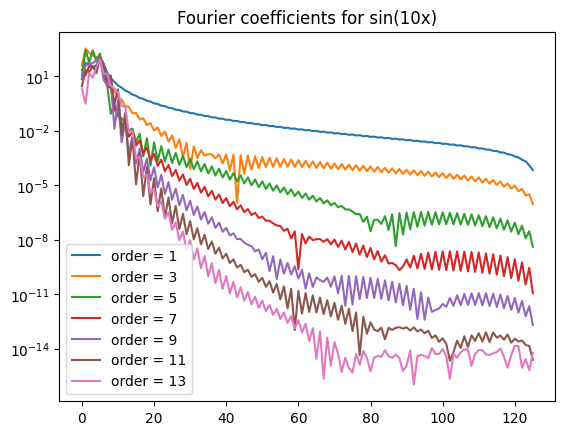

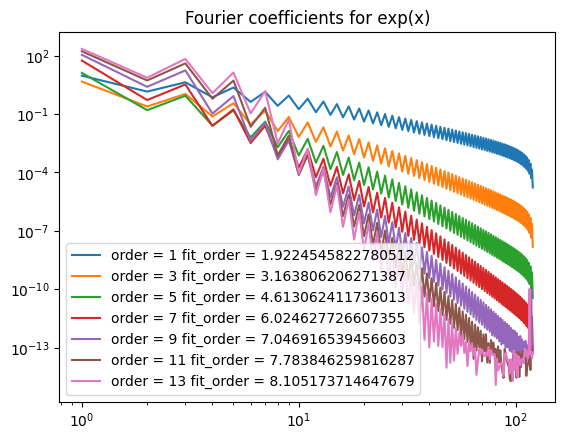

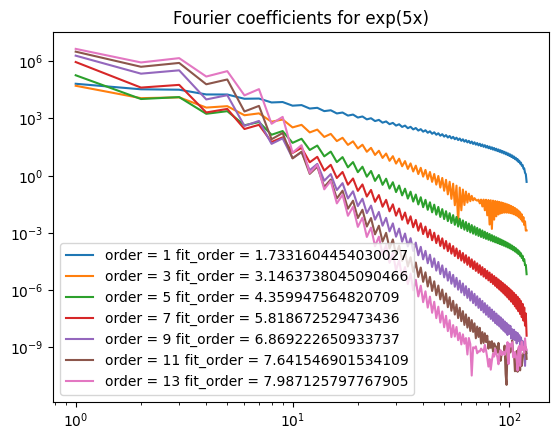

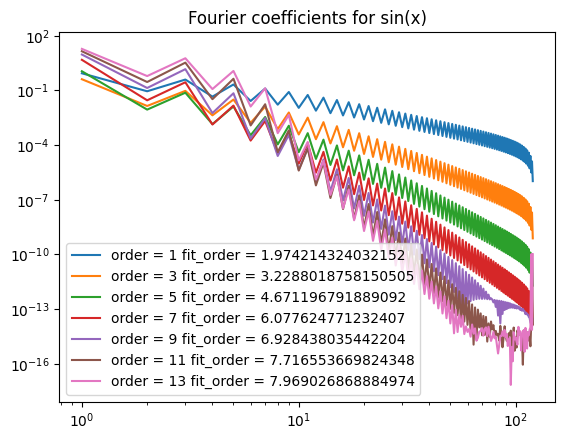

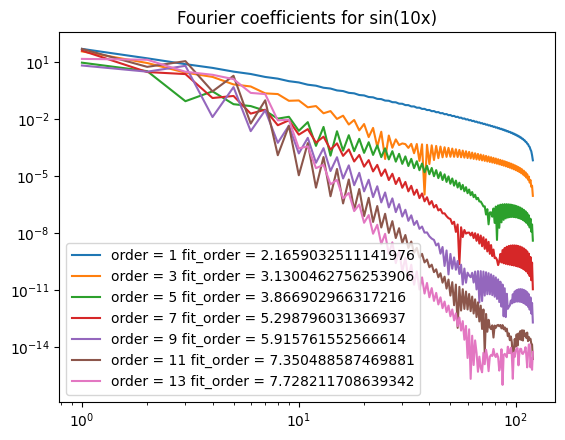

In [50]:
x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        plt.plot(np.abs(fhat), label=f"order = {order}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift 
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        y    = np.abs(fhat)
        y[y==0] = 1e-10
        y    = y[6:]
        r    = np.arange(1, len(y)+1)
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 